In [1]:
import numpy as np 
import pandas as pd 
import cv2 
import matplotlib.pyplot as plt 
import os 
import shutil 

In [2]:

data_dir = os.path.join("/kaggle/input/pokemon-images-scraped-from-bulbapedia/scraped_cleaned_200/")

In [3]:
!ls "/kaggle/input/pokemon-images-scraped-from-bulbapedia/scraped_cleaned_200/Torterra"

000-389Torterra.png	   002-389Torterra_DP_anime.png
001-389Torterra_Dream.png  088-HOME389.png


In [4]:
classes_inorder = [_ for _ in os.listdir(data_dir)]

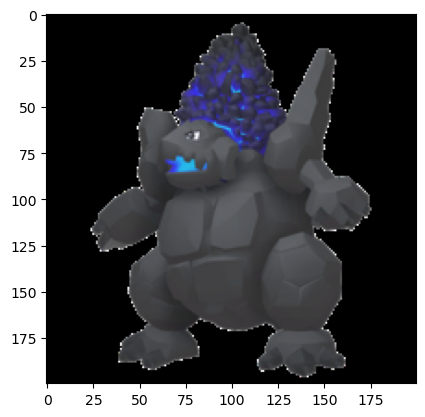

In [5]:
img = cv2.imread("/kaggle/input/pokemon-images-scraped-from-bulbapedia/scraped_cleaned_200/Coalossal/027-HOME839.png")
plt.imshow(img)

In [6]:
# number of classes 
print(f"Number of Classes in the dataset: {len(os.listdir(data_dir))}")

Number of Classes in the dataset: 879


In [7]:
tot_files = 0
for _class in os.listdir(data_dir): 
    class_direc = os.path.join(data_dir, _class)
    onlyfiles = next(os.walk(class_direc))[2] #directory is your directory path as string
    tot_files += len(onlyfiles)
    
print(f"Total Number od data in the dataset: {tot_files}")

Total Number od data in the dataset: 5117


In [8]:
import random 

def create_meta_dataset(data_path, k_way): 
    assert type(k_way) == int, "k_way: requires integer datatype."
    classes = os.listdir(data_path)
    support_classes = random.choices(classes, k=k_way)
    train_classes = [c for c in classes if not c in support_classes]
    query_classes = support_classes
    
    return train_classes, support_classes, query_classes

In [9]:
import matplotlib.pyplot as plt 
import tensorflow as tf

class SiameseDataGenerator: 
    
    def __init__(self):
        pass 
    
    def create_training_data(self, train_data_path, training_classes, classes_inorder): 
        train_X = []
        train_y = []

        for c in training_classes: 
            label_index = classes_inorder.index(c)
            files = next(os.walk(train_data_path + "/" + c))
            files = files[2]
            for f in files:
                file = train_data_path + "/" + c + "/" + f
                img = cv2.imread(file)
                img = cv2.resize(img, (100, 100))
                train_X.append(img)
                train_y.append(label_index)
        return np.array(train_X), np.array(train_y).astype("int")

    def create_support_data(self, support_data_path, support_classes, classes_inorder): 
        support_X = []
        support_y = []

        for c in support_classes: 
            label_index = classes_inorder.index(c)
            files = next(os.walk(support_data_path + "/" + c))
            files = files[2]
            for f in files:
                file = support_data_path + "/" + c + "/" + f
                img = cv2.imread(file)
                img = cv2.resize(img, (100, 100))
                support_X.append(img)
                support_y.append(label_index)
        return np.array(support_X), np.array(support_y).astype("int")

    def create_query_data(self, query_data_path, query_classes, classes_inorder): 
        query_X = []
        query_y = []

        for c in training_classes[:10]: 
            label_index = classes_inorder.index(c)
            files = next(os.walk(query_data_path + "/" + c))
            files = files[2]
            for f in files:
                file = query_data_path + "/" + c + "/" + f
                img = cv2.imread(file)
                img = cv2.resize(img, (100, 100))
                query_X.append(img)
                query_y.append(label_index)
        return np.array(query_X), np.array(query_y).astype("int")
    
    def select_similar_data(self, y, y_label, curr_index):
        similar_indexes = np.where(y==y_label)
        # print(similar_indexes, "sim index")
        similar_indexes = np.delete(similar_indexes, np.where(similar_indexes==curr_index))
        # print("done")
        selected_index = np.random.choice(similar_indexes)
        return selected_index
    
    def select_dissimilar_data(self, num_classes, y, y_label):
        all_classes = np.arange(num_classes+1)
        all_classes = np.delete(all_classes, np.where(y_label==all_classes)[0][0])

        while True: 
            selected_class = np.random.choice(all_classes)
            if  selected_class in y:
                break 
        disimilar_class_indexes = np.where(y==selected_class)
        
        selected_index = np.random.choice(disimilar_class_indexes[0])
        return selected_index
    
    def make_paired_data(self, X, y, num_classes): 
        similar_data = []
        disimilar_data = []
        meta_y = np.zeros(len(X)*2)
        for i in range(len(X)): 
            similar_index = self.select_similar_data(y, y[i], i)
            similar_data.append(X[similar_index])
            dissimilar_index = self.select_dissimilar_data(num_classes, y, y[i])
            disimilar_data.append(X[dissimilar_index])
            
        similar_data = [train_X, similar_data]
        disimilar_data = [train_X, disimilar_data]
        combined_data = np.hstack((similar_data, disimilar_data))
       
        meta_y[: len(train_X)+1] = 0
        meta_y[len(train_X): ] = 1
        return combined_data, meta_y
    
    def visualize(self, pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
        
        num_row = to_show // num_col if to_show // num_col != 0 else 1
        to_show = num_row * num_col
        # Plot the images
        fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
        for i in range(to_show):
            # If the number of rows is 1, the axes array is one-dimensional
            if num_row == 1:
                ax = axes[i % num_col]
            else:
                ax = axes[i // num_col, i % num_col]
            ax.imshow(tf.concat([pairs[0][i], pairs[1][i]], axis=1), cmap="gray")
            ax.set_axis_off()
            if test:
                ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
            else:
                ax.set_title("Label: {}".format(labels[i]))
        if test:
            plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
        else:
            plt.tight_layout(rect=(0, 0, 1.5, 1.5))
        plt.show()
        
    def create_n_way_data(self, n_way, data_path, support_classes, query_classes, classes_inorder): 
        query_set = []
        support_set = [[] for _ in range(n_way)]
        support_y = []
        for outer_ind, sup_class in enumerate(support_classes): 
            src = data_path + "/" + sup_class
            files = next(os.walk(src))
            for ind, file in enumerate(files[2]): 
                file_src = src + "/" + file
                img = cv2.imread(file_src)
                img = cv2.resize(img, (100, 100))
                if ind == 0: 
                    query_set.append(img)
                else: 
                    support_set[outer_ind].append(img)
                
            support_y.append(classes_inorder.index(sup_class))
        
        return np.array(support_set), np.array(support_y), np.array(query_set)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


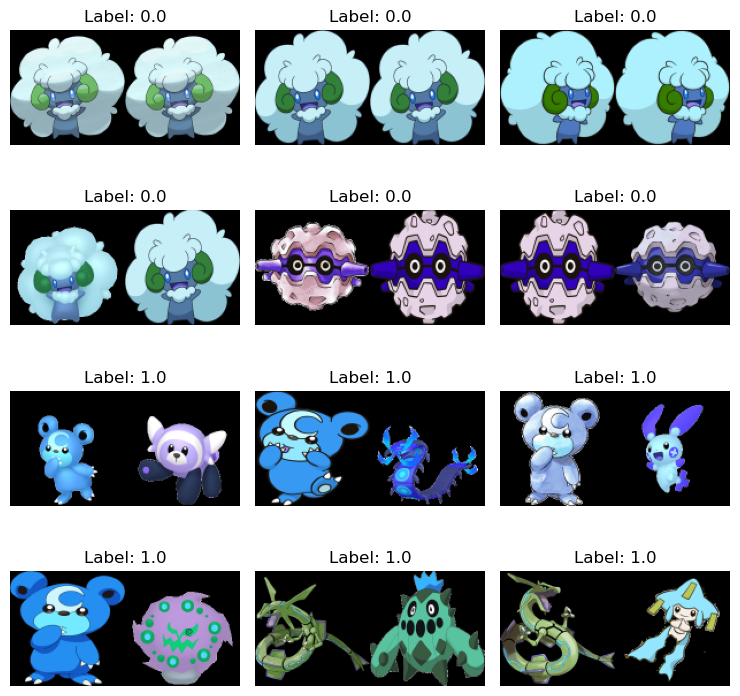

In [10]:
siamese_data_gen = SiameseDataGenerator()
training_classes, support_classes, query_classes = create_meta_dataset(data_dir, 5)
train_X, train_y = siamese_data_gen.create_training_data(data_dir, training_classes, classes_inorder)
num_classes = len(classes_inorder)
combined_data, meta_y = siamese_data_gen.make_paired_data(train_X, train_y, num_classes)
support_set, support_y, query_set = siamese_data_gen.create_n_way_data(5, data_dir, support_classes, query_classes, classes_inorder)
positive_sample = combined_data[:, :6]
negative_sample = combined_data[:, 5900:5906]
visulization_data = np.hstack((positive_sample, negative_sample))
visualization_y = np.concatenate((meta_y[: 6], meta_y[5900: 5906]), axis=0)
siamese_data_gen.visualize(visulization_data, visualization_y, 12, 3)

In [11]:
train_1 = combined_data[0, :] / 255.0
train_2 = combined_data[1, :] / 255.0

del train_X
del combined_data
del train_y
del positive_sample
del negative_sample
del visulization_data

In [14]:
from tensorflow.keras.layers import Dense, Input, Lambda, Add, Conv2D, MaxPooling2D, BatchNormalization, Flatten, AveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import tensorflow as tf 

class SiameseModel: 
    
    def __init__(self): 
        self.siamese_model = None
    
    def EmbeddingConvLayer(self):
        input =Input((100, 100, 3))
        x = BatchNormalization()(input)
        x = Conv2D(32, (5, 5), activation="tanh")(x)
        x = AveragePooling2D(pool_size=(2, 2))(x)
        x = Conv2D(16, (5, 5), activation="tanh")(x)
        x = AveragePooling2D(pool_size=(2, 2))(x)
        x = Flatten()(x)

        x = BatchNormalization()(x)
        x = Dense(10, activation="tanh")(x)
        embedding_network = keras.Model(input, x)

        return embedding_network 
    
    def euclidean_distance(self, vects):
        """
        Find the Euclidean distance between two vectors.

        Arguments:
            vects: List containing two tensors of same length.

        Returns:
            Tensor containing euclidean distance
            (as floating point value) between vectors.
        """
        x, y = vects
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

    def loss(self, margin=1):
        def contrastive_loss(y_true, y_pred):
            """
            Calculates the constrastive loss.

            Arguments:
                y_true: List of labels, each label is of type float32.
                y_pred: List of predictions of same length as of y_true,
                        each label is of type float32.

            Returns:
                A tensor containing constrastive loss as floating point value.
            """
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
            return tf.math.reduce_mean(
                (1 - y_true) * square_pred + (y_true) * margin_square
            )

        return contrastive_loss
    
    def build(self): 
        input_1 = Input((100, 100, 3))
        input_2 = Input((100, 100, 3))

        embedding_network = self.EmbeddingConvLayer()
        net1 = embedding_network(input_1)
        net2 = embedding_network(input_2)
        merge = Lambda(self.euclidean_distance)([net1, net2])
        normal = BatchNormalization()(merge)
        _output = Dense(1, activation="sigmoid")(normal)
        siamese_model = keras.Model(inputs=[input_1, input_2], outputs=_output)
        siamese_model.compile(optimizer=Adam(learning_rate=0.0001), 
                                          loss=self.loss(margin=1), metrics="acc")
        
        self.siamese_model =  siamese_model
    
    def train(self, input1, input2, y, epochs, batch_size):
        history = self.siamese_model.fit([input1, input2], y, batch_size=batch_size,
                                                     epochs=epochs)
        return history, self.siamese_model
    
    def pred_query_set(self, model, n_way, support_set, support_y, query_set): 
    
        result = []
        for query_img in query_set: 
            pred = [0 for _ in range(len(support_set))]
            plt.imshow(query_img)
            print("query_img")
            plt.show()
            print()
            for ind, inner_support_set in enumerate(support_set):
                for i in range(n_way): 
                    if len(inner_support_set) >= i+1: 
                        sup_img = inner_support_set[i]
                        plt.imshow(sup_img)
                        plt.show()
                        print('supo')
                        sup_img = np.reshape(sup_img, (1, 100, 100, 3))
                        query_img = np.reshape(query_img, (1, 100, 100, 3))
                        prob_val = model.predict([sup_img, query_img], verbose=False)
                        print(prob_val, ind, "prediction")
                        pred[ind] += prob_val
                pred[ind] += pred[ind] / len(inner_support_set)
            result.append(np.array(pred).argmax())
            print(result)
            
        return result
        
    def save(self, file_path): 
        self.siamese_model.save(file_path)
        print("Saved Model Successfully")

In [ ]:
siamese_model = SiameseModel()
siamese_model.build()
history, model = siamese_model.train(train_1, train_2, meta_y, 25, 32)

In [ ]:
siamese_model = SiameseModel()
res = siamese_model.pred_query_set(model, 2, support_set, support_y, query_set)